In [1]:
import os
import pandas as pd
import torch
from transformers import AlbertForSequenceClassification, AlbertTokenizer, Trainer, TrainingArguments
from torch.quantization import quantize_dynamic
import torch
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:


# Load the model from the checkpoint
checkpoint_path = "./results/albert/checkpoint-9900/"
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
model = AlbertForSequenceClassification.from_pretrained(checkpoint_path)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:

# Load data
export_dir = Path(os.getcwd())
data_path = Path(export_dir, "data")
train_file = Path(data_path, 'train_data_only_text_and_labels.csv')
eval_file = Path(data_path, 'eval_data_only_text_and_labels.csv')
test_file = Path(data_path, 'test_data_only_text_and_labels.csv')

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)
test_df = pd.read_csv(test_file)


In [6]:
import torch
from transformers import AlbertForSequenceClassification, AlbertTokenizer, Trainer, TrainingArguments
from torch.quantization import quantize_dynamic
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import numpy as np
import os
import copy

# Load the model from the checkpoint
checkpoint_path = "./results/albert/checkpoint-9900/"
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
model = AlbertForSequenceClassification.from_pretrained(checkpoint_path)

# Tokenize and prepare datasets
def tokenize_and_encode(df):
    encodings = tokenizer(list(df['text_combined']), truncation=True, padding=True, return_tensors='pt')
    labels = torch.tensor(df['label'].values)
    return encodings, labels

train_encodings, train_labels = tokenize_and_encode(train_df)
eval_encodings, eval_labels = tokenize_and_encode(eval_df)
test_encodings, test_labels = tokenize_and_encode(test_df)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
eval_dataset = CustomDataset(eval_encodings, eval_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

# Evaluate original model size
def get_model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # Size in MB

original_model_size = get_model_size(model)

# Apply dynamic quantization to the linear layers
model.to('cpu')  # Ensure model is on CPU
quantized_model = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

# Evaluate quantized model size
quantized_model_size = get_model_size(quantized_model)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


KeyboardInterrupt: 

In [20]:
print(quantized_model_size)
total_params = sum(p.numel() for p in quantized_model.parameters())

print(f"Total number of parameters: {total_params}")

14.912109375
Total number of parameters: 3909120


#### Save model

In [22]:
quantized_model_path = "./results/albert/fine_tune/quantize/quantized_model.pth"

# Save the quantized model
torch.save(quantized_model.state_dict(), quantized_model_path)

# Optionally, you may also want to save the tokenizer and any other necessary files
tokenizer.save_pretrained("./results/albert/fine_tune/quantize/quantized_model_tokenizer")


('./results/albert/fine_tune/quantize/quantized_model_tokenizer/tokenizer_config.json',
 './results/albert/fine_tune/quantize/quantized_model_tokenizer/special_tokens_map.json',
 './results/albert/fine_tune/quantize/quantized_model_tokenizer/spiece.model',
 './results/albert/fine_tune/quantize/quantized_model_tokenizer/added_tokens.json')

In [9]:
torch.save(quantized_model, "./results/albert/fine_tune/quant/quantized_model.pth")



Quantized model saved to ./results/albert/fine_tune/quant/quantized_model.pth


#### Load saved model

In [7]:
quantized_model2 = torch.load("./results/roberta/fine_tune/quant/quantized_model.pth")

In [8]:

total_params = sum(p.numel() for p in quantized_model2.parameters())

print(f"Total number of parameters: {total_params}")

Total number of parameters: 52099072


### Evaluation

In [9]:
test= pd.read_csv(Path(data_path,'test_data_only_text_and_labels.csv'))
test.head()
X_test = test["text_combined"].tolist()
y_test = test["label"]


Confusion Matrix:
[[ 586 7333]
 [ 467 8112]]
Accuracy: 0.5272154200509153
Precision: 0.5252185173195209
Recall: 0.9455647511364961
F1-Score: 0.6753246753246753
AUC: 0.5696060242546999


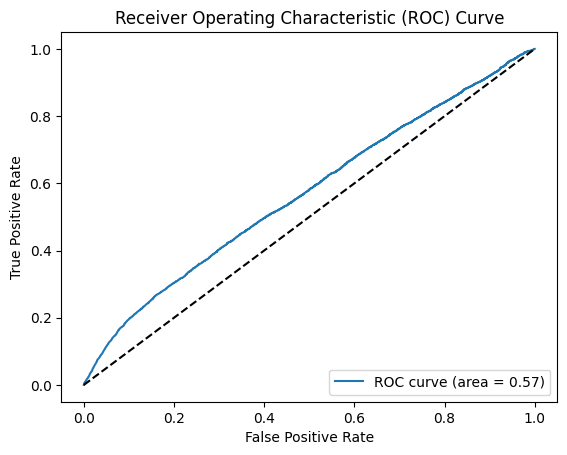

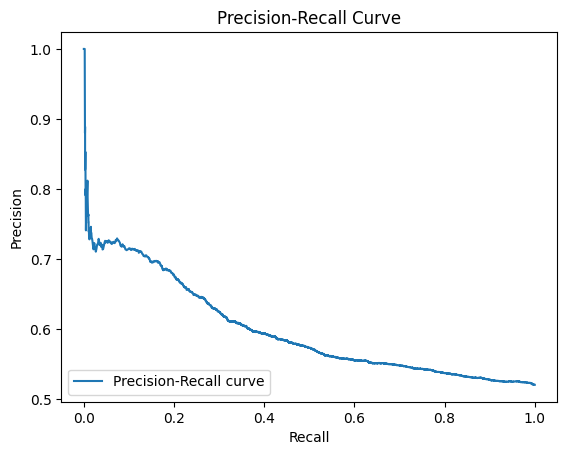

In [12]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Function to evaluate the model on the test set in batches
def evaluate_in_batches(model, tokenizer, X_test, y_test, batch_size):
    device = torch.device("cpu")  # Change to "cuda" if GPU is available and required
    model.to(device)
    model.eval()

    # Split the test set into batches
    num_batches = len(X_test) // batch_size + (1 if len(X_test) % batch_size != 0 else 0)

    all_predictions = []
    all_probs = []
    all_true_labels = []

    with torch.no_grad():
        for i in range(num_batches):
            # Get the batch data
            batch_texts = X_test[i * batch_size: (i + 1) * batch_size]
            batch_labels = y_test[i * batch_size: (i + 1) * batch_size]

            # Tokenize the batch
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Get logits from the model
            outputs = model(**inputs)
            logits = outputs.logits.cpu()
            probs = torch.nn.functional.softmax(logits, dim=-1).cpu()

            # Get the predicted labels
            predictions = torch.argmax(probs, dim=1).cpu()

            # Store the results
            all_predictions.append(predictions.numpy())
            all_probs.append(probs[:, 1].numpy())
            all_true_labels.append(batch_labels.to_numpy())

    # Concatenate all batch results
    y_pred = np.concatenate(all_predictions)
    y_scores = np.concatenate(all_probs)
    y_true = np.concatenate(all_true_labels)

    # Calculate evaluation metrics
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)

    # Print results
    print("Confusion Matrix:")
    print(cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("AUC:", auc)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    plt.figure()
    plt.plot(recall_vals, precision_vals, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    return cm
# Example usage
batch_size = 500  # Set the desired batch size
cm = evaluate_in_batches(quantized_model2, tokenizer, X_test, y_test, batch_size)


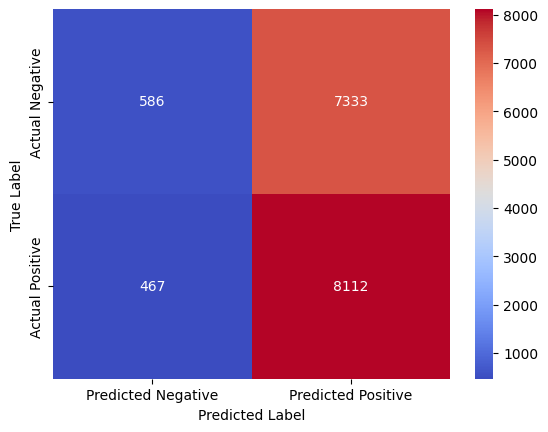

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Define the data matrix
data = cm

# Define axis labels
x_labels = ['Predicted Negative', 'Predicted Positive']
y_labels = ['Actual Negative', 'Actual Positive']

# Create the heatmap with values inside cells
ax = sns.heatmap(data, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
                 xticklabels=x_labels, yticklabels=y_labels)

# Set axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()


In [1]:
### EVAL WITH output

Confusion Matrix:
[[ 596 7323]
 [ 458 8121]]
Accuracy: 0.5283670747969451
Precision: 0.5258352758352758
Recall: 0.9466138244550647
F1-Score: 0.6761020688506848
AUC: 0.56887528951228
eval_time: 9157.627004146576


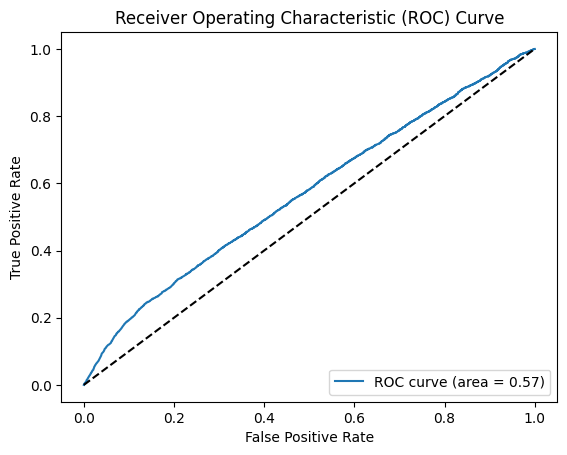

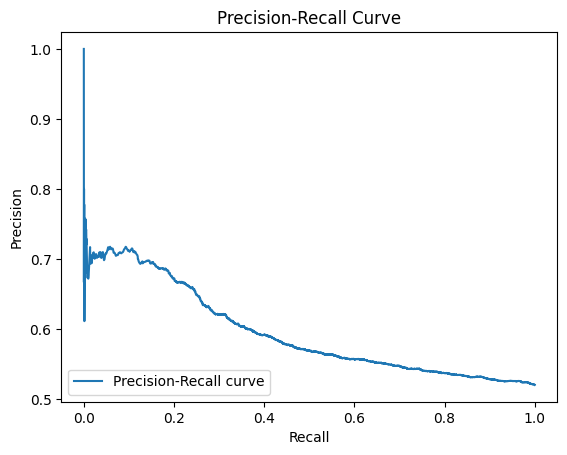

In [10]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import time
# Function to evaluate the model on the test set in batches
def evaluate_in_batches(model, tokenizer, X_test, y_test, batch_size):
    device = torch.device("cpu")  # Change to "cuda" if GPU is available and required
    model.to(device)
    model.eval()

    # Split the test set into batches
    num_batches = len(X_test) // batch_size + (1 if len(X_test) % batch_size != 0 else 0)

    all_predictions = []
    all_probs = []
    all_true_labels = []
    start_time = time.time()
    with torch.no_grad():
        for i in range(num_batches):
            # Get the batch data
            batch_texts = X_test[i * batch_size: (i + 1) * batch_size]
            batch_labels = y_test[i * batch_size: (i + 1) * batch_size]

            # Tokenize the batch
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Get logits from the model
            outputs = model(**inputs)
            logits = outputs.logits.cpu()
            probs = torch.nn.functional.softmax(logits, dim=-1).cpu()

            # Get the predicted labels
            predictions = torch.argmax(probs, dim=1).cpu()

            # Store the results
            all_predictions.append(predictions.numpy())
            all_probs.append(probs[:, 1].numpy())
            all_true_labels.append(batch_labels.to_numpy())

    # Concatenate all batch results
    y_pred = np.concatenate(all_predictions)
    y_scores = np.concatenate(all_probs)
    y_true = np.concatenate(all_true_labels)
    total_time = time.time() - start_time
    # Calculate evaluation metrics
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)
    evaluation_results = {
        "Confusion_Matrix": cm,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "Evaluation_Time": total_time
    }
    # Print results
    print("Confusion Matrix:")
    print(cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("AUC:", auc)
    print("eval_time:", total_time)
    # ROC Curve
    with open(f'./results/albert/fine_tune/quant/quantized_model_eval_results.txt', 'w') as f:
        f.write(f"{evaluation_results}\n\n")
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    plt.figure()
    plt.plot(recall_vals, precision_vals, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    return cm
# Example usage
batch_size = 500  # Set the desired batch size
cm = evaluate_in_batches(quantized_model2, tokenizer, X_test, y_test, batch_size)

 